# Lab 11: ODEs, Failure Rates, and Evolutionary Games

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
import scipy as sp
import scipy.stats as st
from scipy.integrate import odeint
print 'Modules Imported!'

Modules Imported!


In this lab we're to going analyze evolutionary games using drift analysis. In order to do this, we first need to determine how to integrate ordinary differential equations. So, we begin with a brief exposure of how to achieve this in Python. While we're at it, we'll do a short exercise about failure rate functions.  Then we examine some evolutionary games, using both a stochastic model and a deterministic model, which involves the differential equations.

## Integration of ODEs

This section gives an introdution to integrating ordinary differential equations (odes), with an application to the calculation of a CDF from a failure rate function.  If you recall from your math classes we can describe an ODE as the following:

$\dot{y}=f(y),$ 

where both $y$ and the function $f$ are vector valued, and $\dot{y}$ is shorthand for $\frac{dy}{dt}.$   The variables being vector valued simply implies that we could have a system of dependent one dimensional (1D) ODEs as opposed to just a single one dimensional variable.  Let's look at the following system:

\begin{eqnarray*}
\binom{\dot{y_0}}{\dot{y_1}} = \binom{2y_1-0.1y_0}{-y_0}
\end{eqnarray*}
with the initial condition $y_{init}=\binom{y_1(0)}{y_2(0)}=\binom{1}{1}.$

Our goal in using Python is not to find a closed form solution to the ODE as you would have probably done in your math class, but to numerically integrate it and produce a graphical solution. In order to do this we use the odeint method from scipy.integrate. It takes a function with an initial value and specified times at which the solution is to be output. Internally, the numerical method will often use a much finer grid of time points to solve the ode -- but that is none of your concern.   The times you put in are the times at with the method needs to provide the values of the solution. Look how it is used below:

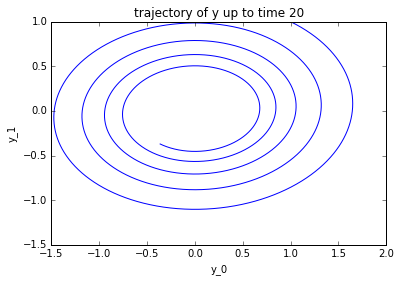

In [18]:
# Simple example integrating a 2d ordinary differential equation (ode) dy/dt=f(y,t) 
# Note that the odeint package is imported in the code at the beginning of this file.

# Function to integrate over
def f(y,t):    
    return np.array([2.*y[1]-.1*y[0],-y[0] ])

time=np.linspace(0.0,20.0,10000)   # The times at which the solution is output. Where y comes from outside of the contour
yinit=np.array([1.0,1.0])   # The initial condition
y=odeint(f,yinit,time)      

plt.plot(y[:,0],y[:,1])
plt.title('trajectory of y up to time 20')
plt.ylabel('y_1')
plt.xlabel('y_0')


Typically in a plot like this you would add an arrow to indicate the direction of time in the graph. However, we know the initial state is $y_{init}=\binom{1}{1}.$ So as time increases, the trajectory moves concentrically inwards in a clockwise fashion. Depending on how much of differential equations you remember, this solution should make sense. The equation happens to have a linear form and can be written as $\dot y = Ay$ where
$
A=\left( \begin{array}{cc}  -0.1  &  2  \\  -1  & 0 \end{array} \right).
$
The eigenvalues of $A$ are complex with negative real parts, so we would expect a decaying oscillatory behavior. (If you didn't follow that, don't worry about it.)

As a simple application of integrating a 1D (one-dimensional) ode, the following code calculates a CDF $F$ from its failure rate function $h.$ But first, let's look at some theory to remember what a failure rate function is. If we let $T$ be a positive random variable with a pdf $f_T$ then
the failure rate function is defined by the following:

$$h(t)=\lim_{\epsilon \to 0} \frac{P(t<T \leq t+\epsilon | T>t)}{\epsilon}$$

Equivalently, an object having failure rate function $h$ means that for any $t > 0,$ given
that the object is still working at time $t$, the probability it will fail in the next
$\epsilon$ time units is $h(t)\epsilon + o(\epsilon)$.  (As usual, $o(\epsilon)$ represents an error term such that $o(\epsilon)/\epsilon \to 0$ as $\epsilon\to 0.$)  With a little bit more derivation (shown in Section 3.9 of your ECE 313 text), we can see that:

$$h(t) = \frac{f_T(t)}{1-F_T(t)}$$

Of course, the pdf $f_T$ is the derivative of the CDF $F_T$. Here's where your 1D ODE comes into play. Given a failure rate function, we want to be able to calculate the CDF. We can easily turn this into an ODE. 

$f_T(t) = (1-F_T(t))h(t)$

Let $F_T(t) = y$ and  $f_T(t) = \frac{dy}{dt} = \dot{y}$, then:

$\dot{y} = (1-y)h(t)$

Now we have our differential equation set up and we can solve it by the same method used in the previous example. For the code below, we define a particular bathtub shaped failure rate function to model the lifetime of a component such as a hard disk drive. There is a high, but decreasing initial rate of failure, followed be a period with a very low rate failure, followed by an increasing rate of failure. You should be able to think of reasons why an object might exhibit this type of failure rate function. Notice that the CDF behaves as we would expect: always between 0 and 1, and reactive to $h(t)$.

If you examine the ECE 313 notes you'll see another way to determine $F_T,$  namely, using
$F_T(t) = 1- \exp \left( \int_o^t -h(s) ds \right)$.  The point here, though, is to get some practice using
odeint, instead of using this formula.

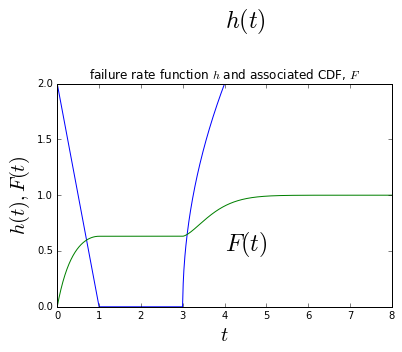

In [25]:
# Calculation of CDF from its failure rate function, using dF/dt=(1-F(t))h(t)
from scipy.integrate import odeint

def h(t):   # h is the failure rate function with a bathtub shape
    if t<1:
        return (1-t)*2
    elif t<3:
        return 0.0
    else:
        return (np.sqrt(t-3))*2

def Fdot(y,t):    
    return (1-y)*h(t)

t_max=8.0  #  Select so that F(t_max) is very close to one
time=np.linspace(0.0,t_max,1000)
Finit=0.0
F=odeint(Fdot,Finit,time)

plt.plot(time,map(h,time))
plt.text(4,h(4)+0.5, r'$h(t)$',fontsize=24) #Plots labels in the graph
plt.text(4,0.5, r'$F(t)$',fontsize=24) 

plt.plot(time,F)
plt.title('failure rate function $h$ and associated CDF, $F$')
plt.axis(ymin=0,ymax=2.0)
plt.ylabel('$h(t), F(t)$',fontsize=20)
plt.xlabel('$t$',fontsize=20)

**<SPAN style="BACKGROUND-COLOR: #C0C0C0">Problem 1:</SPAN>** Using the information on failure rate functions and the example above, do the following:
<ol>
<li> Write code that, given the failure rate function of a random variable $T$, computes the mean lifetime, $E[T].$  Use this code to determine the mean lifetime for the example given above.  (Hint: An easy way to do this problem is to use the area rule for expectations. Since $T$ is nonnegative, the area rule for expectations gives $E[T]=\int_0^\infty(1-F(t)) dt.$
The integral $\int_0^\infty (1-F(t)) dt$ is approximately equal to
$\int_0^{t_{max}} (1-F(t)) dt,$  which, by the definition of Riemann integration, is approximately equal to
$h \sum_{i=1}^{1000} (1-F(h_i)) $ where $h=t_{max}/1000.$  Basically the code above returns the samples $F(h_i)$ so all you need to do is subtract these values from 1, sum them up and multiply by $h$.)
<li> What happens to $E[T]$ if the failure rate function is doubled for all time? Print out the new value of $E[T]$.
</ol>

In [21]:
# Your code here
# Calculation of CDF from its failure rate function, using dF/dt=(1-F(t))h(t)
from scipy.integrate import odeint

def h(t):   # h is the failure rate function with a bathtub shape
    if t<1:
        return 1-t
    elif t<3:
        return 0.0
    else:
        return np.sqrt(t-3)

def Fdot(y,t):    
    return (1-y)*h(t)

t_max=8.0  #  Select so that F(t_max) is very close to one
time=np.linspace(0.0,t_max,1000)
Finit=0.0
F=odeint(Fdot,Finit,time)
# print F
sum_F = 0.
h = t_max / 1000.
for i in range(1000):
    sum_F = sum_F + (1 - F[i])
avg = sum_F * h
print 'Average:', avg

Average: [ 2.65652422]


__Answer:__ (Your answer here)
2. When the failure rate rate function grows by two at all points, the average lifetime grows.

In [26]:
# Your code here
# Calculation of CDF from its failure rate function, using dF/dt=(1-F(t))h(t)
from scipy.integrate import odeint

def h(t):   # h is the failure rate function with a bathtub shape
    if t<1:
        return (1-t)*2
    elif t<3:
        return (0.0)*2
    else:
        return (np.sqrt(t-3))*2

def Fdot(y,t):    
    return (1-y)*h(t)

t_max=8.0  #  Select so that F(t_max) is very close to one
time=np.linspace(0.0,t_max,1000)
Finit=0.0
F=odeint(Fdot,Finit,time)
# print F
sum_F = 0.
h = t_max / 1000.
for i in range(1000):
    sum_F = sum_F + (1 - F[i])
avg = sum_F * h
print 'Average:', avg

Average: [ 1.55044486]


**<SPAN style="BACKGROUND-COLOR: #C0C0C0">End of Problem 1</SPAN>** 

## Evolutionary games (replicator dynamics):

Consider a population of individuals, where each individual is of some type.  Suppose individuals have occasional pairwise encounters.  During an encounter the two individuals involved play a two player symmetric game in which the strategies are the types of the individuals.   As a result of the encounter, each of the two individuals produces a number of offspring of its same type, with the number being determined by a fitess table or, equivalently, a fitness matrix.   For example, consider a population of crickets such that each cricket is either small or large.   If two small crickets meet each other then they each spawn five more small crickets.  If a small cricket encounters a large cricket then the small cricket spawns one more small cricket and the large cricket spawns eight new large crickets.   If two large crickets meet then each of them spawns three new large crickets.  We can summarize these outcomes using the following table:
$$\begin{array}{c|cc}  & small & large  \\ \hline
    small & 5 & 1  \\
    large & 8 & 3
    \end{array}$$
or by a fitness matrix
$$F=\left( \begin{array}{cc}  5 & 1 \\ 8 & 3  \end{array}\right).$$ 
Associating 0 with "small" and 1 with "large,"  we see that if a type i individual encounters a type j individual, then the type i individual spawns F[i,j] new individuals of type i, and the type j individual spawns F[j,i] new individuals of type j. Below is a stochastic simulation for this game where we start with a population of four small crickets and four large crickets. It may be a useful exercise for you to think of how the values for $a$ and $b$ were created.


In [22]:
# Stochastic simulation of replicator dynamics for cricket game

F=np.array([[5,1],[8,3]])  # fitness matrix

n=np.array([4,4])  #[number of small crickets, number of large crickets], initialized
print "                                   State      Fractions of each type"
print "Initially                        ", n, "      ", n/1./np.sum(n)

T = 1000 #total number of encounters

for k in range(T):   # k tracks number of encounters
    a=n[0]*(n[0]-1.0)/((n[0]+n[1])*(n[0]+n[1]-1))  # probability both players are type 0
    b=2*n[0]*n[1]/((n[0]+n[1])*(n[0]+n[1]-1.0))  # probability one player of each type
    U=np.random.rand()
    if U<=a:
        n+=[2*F[0,0],0]
        print "Round",k+1,"two small crickets meet ", n, n/1./np.sum(n)
    elif a<U<=a+b:
        n+=[F[0,1],F[1,0]]
        print "Round",k+1,"a small meets a large   ", n, n/1./np.sum(n)
    else:
        n+=[0,2*F[1,1]]
        print "Round",k+1,"two large crickets meet ", n, n/1./np.sum(n)
# print "Round",k+1,"two large crickets meet ", n, n/1./np.sum(n)

                                   State      Fractions of each type
Initially                         [4 4]        [ 0.5  0.5]
Round 1 a small meets a large    [ 5 12] [ 0.29411765  0.70588235]
Round 2 a small meets a large    [ 6 20] [ 0.23076923  0.76923077]
Round 3 a small meets a large    [ 7 28] [ 0.2  0.8]
Round 4 a small meets a large    [ 8 36] [ 0.18181818  0.81818182]
Round 5 two large crickets meet  [ 8 42] [ 0.16  0.84]
Round 6 two large crickets meet  [ 8 48] [ 0.14285714  0.85714286]
Round 7 two large crickets meet  [ 8 54] [ 0.12903226  0.87096774]
Round 8 two large crickets meet  [ 8 60] [ 0.11764706  0.88235294]
Round 9 two large crickets meet  [ 8 66] [ 0.10810811  0.89189189]
Round 10 a small meets a large    [ 9 74] [ 0.10843373  0.89156627]
Round 11 two large crickets meet  [ 9 80] [ 0.1011236  0.8988764]
Round 12 two large crickets meet  [ 9 86] [ 0.09473684  0.90526316]
Round 13 a small meets a large    [10 94] [ 0.09615385  0.90384615]
Round 14 a small meets a 

The above simulation displays, after each encounter, the number of individuals of each type and the fraction of individuals of each type.   Run the simulation multiple times for different initial conditions.  
<br>**<SPAN style="BACKGROUND-COLOR: #C0C0C0">Problem 2:</SPAN>**  Answer the following questions.   You do not need to provide code for this problem, but explain your answers.  
<ol>
<li> How quickly does the total population grow if initally all the crickets are small?  
<li> How quickly does the total population grow if initally all the crickets are large? 
<li> Do the fractions converge to a stable equilibrium in which the fractions of both small and large crickets are nonzero? (To explore convergence you may need to increase the number of encounters simulated.)
</ol>

__Answer:__ (Your answer here)
1. Only the small crickets grows. It grows by 10 per round.
2. Only the large crickets grows. It grows by 6 per round.
3. It converges, because the amount of large crickets will keep growing more sigfinicantly than the amount of small crickets.  Eventually the ratio between the large crickets and small crickets will approach infinity.  

**<SPAN style="BACKGROUND-COLOR: #C0C0C0">End of Problem 2</SPAN>** 

The code given next is essentially the same as above.  One difference is a time variable is added such that the average rate that an individual cricket has encounters is proportional to the total number of crickets.  This results in exponential growth of the population with time.    Another difference is that population sizes are saved and plotted.

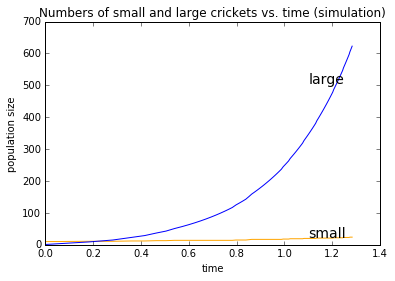

In [38]:
# Stochastic simulation of replicator dynamics for cricket game
# Time is scaled so contact rate of each individual is one per unit time
# The evolution trajectory is stored an plotted

F=np.array([[5,1],[8,3]])  # fitness matrix
n_max=100  # maximum number of interactions
n=np.zeros((n_max,2),dtype=float)
time=np.zeros(n_max,dtype=float)
 
n[0,0], n[0,1] = 10,1 # initial [number of small crickets, number of large crickets]

for k in range(n_max-1):
    time[k+1]=time[k]+2.0/sum(n[k,:])   # The 2 is here because two individuals make contact at a time
    a=n[k,0]*(n[k,0]-1.0)/((n[k,0]+n[k,1])*(n[k,0]+n[k,1]-1))  # probability both players are type 0
    b=2*n[k,0]*n[k,1]/((n[k,0]+n[k,1])*(n[k,0]+n[k,1]-1.0))  # probability one player of each type
    U=np.random.rand()
    if U<=a:
        n[k+1,:]= n[k,:] + [2*F[0,0],0]
    elif a<U<=a+b:
        n[k+1,:]=n[k,:] + [F[0,1],F[1,0]]
    else:
        n[k+1,:]= n[k,:] + [0,2*F[1,1]]

plt.plot(time,n[:,0],'orange')
plt.plot(time,n[:,1],'blue')
plt.text(1.1,n[80,0], r'small',fontsize=14)
plt.text(1.1,n[80,1], r'large',fontsize=14)
plt.xlabel('time')
plt.ylabel('population size')
plt.title("Numbers of small and large crickets vs. time (simulation)")


The following code computes the deterministic analog of the cricket evolution.  The basic idea is that if the current population is [n[0], n[1]] then the drift (i.e. the expected rate of increase) of n[0] is n[0]  multiplied by the expected number of small crickets generated by a small cricket if an encounter happens.  That is true because each of the existing small crikets is having encounters at expected rate one.   To calculate the mean number of new small crickets generated by the encounter of a small cricket with a randomly selected other cricket, we use the law of total probability.  The encountered cricket is type zero with probabiity n[0]/(n[0]+n[1]), which results in F[0,0] new crickets of type zero, and the encountered cricket is type one with probability n[1]/(n[0]+n[1]), which results in F[0,1] new crickets of type zero.   Combining we get
$$
\dot{n}[0] = n[0]*(F[0,0]*n[0]+F[0,1]*n[1])/(n[0]+n[1])
$$
The equation just derived is based on the law of large numbers (LLN).  If the population is fairly large then no one individual plays a major role in the evolution.  Over a small period of time the ratios of small and large crickets is nearly constant, so the number of new crickets of each type in each time slot are nearly independent and identically distributed.   The LLN suggests approximating the sum of number of individuals of each type by the expected numbers of individuals of each type.  That's how we arrive at a deterministic differential equation.

A similar expression holds for the derivative of n[1], and the two equations can be writen in matrix form as
$$
\dot{n} = diag(n)*F*n/sum(n)
$$
where diag(n) is the diagonal matrix with n[0] and n[1] on the diagonal, and "$*$" represents usual matrix multiplication.   (In the python code below, "$*$" denotes element by element multiplication, which is used instead of creating a diagonal matrix, and np.dot is used for ordinary matrix multiplication.)

Text(0.5,1,u'Numbers of small and large crickets vs. time (ode prediction)')

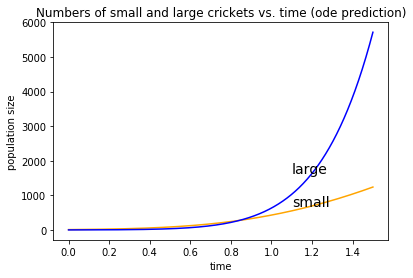

In [44]:
# Deterministic (ODE) replicator dynamics for cricket game
from scipy.integrate import odeint

F=np.array([[5,1],[8,3]])  # fitness matrix

def f(n,t):
    return (n*np.dot(F,n)/sum(n)/1.)

ninit=[10,1]    # initial [number of small crickets, number of large crickets]
time=np.linspace(0.0,1.5, 1000)

n=odeint(f,ninit,time)

plt.plot(time,n[:,0],'orange')
plt.plot(time,n[:,1],'blue')
plt.xlabel('time')
plt.text(1.1,n[800,0], r'small',fontsize=14)
plt.text(1.1,n[800,1], r'large',fontsize=14)
plt.ylabel('population size')
plt.title("Numbers of small and large crickets vs. time (ode prediction)")

<br>**<SPAN style="BACKGROUND-COLOR: #C0C0C0">Problem 3:</SPAN>** Run the code above and compare the output to the output of the previous code for stochastic evolutionary dynamics.  Try different intial conditions such as [0,4], [4,0], and [10,1]. Comment on how the result of this compares to our previous simulation. Is the behavior similar?

__Answer__: (Your answer here)
The shapes of the contours are quite similiar.  But the simulation which added time as a variable has a faster population growth rate.

**<SPAN style="BACKGROUND-COLOR: #C0C0C0">End of Problem 3</SPAN>** 

If we let $\theta[0]=\frac{n[0]}{n[0]+n[1]}$ and $\theta[1]=\frac{n[1]}{n[0]+n[1]}$ then the vector $\theta=\binom{\theta[0]}{\theta[1]}$ describes the fractions of the popuation of each type.  It's entries sum to one.  Using the chain rule of calculus we can derive the following differential equation for $\theta$ from the above ode for $n$:
$$
\dot{\theta} = diag(\theta) \left( F\theta - \mathbf{1} \theta^T F \theta \right)
$$
where $\mathbf{1}$ is the column vector of ones (the derivation is a bit involved, try deriving it by yourself if interested, but it is not required). The two components of the vector $F \theta$ give the average fitness level of small crickets and large crickets, respectively, in an encounter with a cricket selected randomly from the population.   And $\theta^T F \theta$ is the weighted average of that vector, giving the average fitness over all crickets in the population.   Thus, $\theta[0]$ is increasing exactly when the fitness of small crickets is greater than the average fitness.

<br>**<SPAN style="BACKGROUND-COLOR: #C0C0C0">Problem 4:</SPAN>**

1. Modify the above code to integrate the equation for the $\theta$ vector to obtain $\theta$ vs. time.
To check your answer, compare it to what you get by first computing the trajectory of $n$ and then calculating $\theta$ from $n.$  (The code given above for deterministic evolution of n works for any number of types, not just two types. A problem below involves three types of individuals, so it'd be nice if you could implement your code for computing $\theta$ to work for any number of types.) __Be careful when you write your program, since matrix multiplication in Python can be tricky. Understand "$*$" multiplication and np.dot multiplication first. After each small step, debug, confirm, then proceed.__ 
2. Using the fact that $\theta[1]=1-\theta[0],$  a differential equation can be derived for the variable $\theta[0]$ alone.
Plot the function $h$ on the interval $[0,1]$ such that $\dot{\theta}[0]=h(\theta[0]).$ Note that the horizontal axis of the graph is $\theta$, the vertical axis is $\dot{\theta}$. (You can just do this
numerically.  It can also be done algebrically; in fact $h$ is a cubic polynomial, but it is a bit complicated to find the polynomial.)
3. What are the zeroes of $h$ (those are the equilibrium points of $\theta[0]$)?  Which of those are stable (in the sense that if $\theta[0]$ is slightly moved away from the equilibrium point, it returns to the equilibrium point)?

[[ 0.5         0.5       ]
 [ 0.49906174  0.50093826]
 [ 0.49812384  0.50187616]
 ..., 
 [ 0.03622383  0.96377617]
 [ 0.03611725  0.96388275]
 [ 0.03601097  0.96398903]]


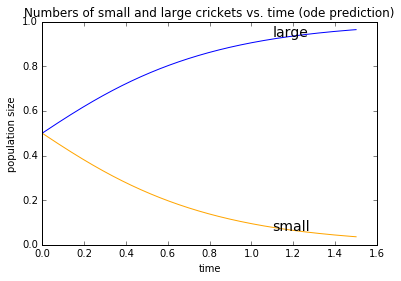

In [2]:
# Your code here
from scipy.integrate import odeint

F=np.array([[5,1],[8,3]])  # fitness matrix

def f(n,t):
    l = np.ones(2) #column vector of ones l
    diag = np.array([[n[0],0],[0,n[1]]])
    Ft = np.dot(F,n)
    tFt = np.dot(np.transpose(n),Ft)
    ltFt = np.dot(l,tFt)
    altFt = (Ft-ltFt)
#     return (np.dot(diag,altFt)/1.)
    return (np.dot(diag,altFt)/1.)

ninit=[1.,1.]    # initial [number of small crickets, number of large crickets]
time=np.linspace(0.0,1.5, 1000)
th0 = ninit[0]/(ninit[0]+ninit[1])
thinit = [th0, 1.-th0]
# print thinit
n=odeint(f,thinit,time)
print n

plt.plot(time,n[:,0],'orange')
plt.plot(time,n[:,1],'blue')
plt.xlabel('time')
plt.text(1.1,n[800,0], r'small',fontsize=14)
plt.text(1.1,n[800,1], r'large',fontsize=14)
plt.ylabel('population size')
plt.title("Numbers of small and large crickets vs. time (ode prediction)")

[ 0.  0.]


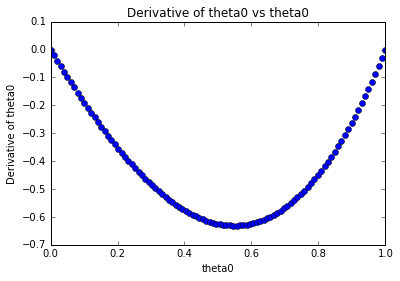

In [16]:
# Your code here
# Deterministic (ODE) replicator dynamics for cricket game
from scipy.integrate import odeint

F=np.array([[5,1],[8,3]])  # fitness matrix

def f(n):
    l = np.ones(2) #column vector of ones l
    diag = np.array([[n[0],0],[0,n[1]]])
    Ft = np.dot(F,n)
    tFt = np.dot(np.transpose(n),Ft)
    ltFt = np.dot(l,tFt)
    altFt = (Ft-ltFt)
    return (np.dot(diag,altFt)/1.)

def der(th0):
    thin = [th0, 1.-th0]
    return f(thin)
ninit=[1,1]   # initial [number of small crickets, number of large crickets]
th0 = ninit[0]/(ninit[0]+ninit[1])
th0_p = der(th0)
print th0_p

theta0 = np.linspace(0.,1.,100)
y = map(der,theta0)
theta0_p = [i[0] for i in y]
plt.plot(theta0,theta0_p,'o')
# plt.plot(time,n[:,1],'blue')
plt.xlabel('theta0')
plt.ylabel('Derivative of theta0')
plt.title("Derivative of theta0 vs theta0")

__Answer:__ (Your answer here)
3. The zeros are at 0 and 1.  And point at 1.0 is stable because the slope is positive at this point.

**<SPAN style="BACKGROUND-COLOR: #C0C0C0">End of Problem 4</SPAN>** 

The overall behavior in evolutionary games depends heavily on the fitness matrix $F.$   Another choice of $F$ corresponds to the so-called doves and hawks evolution game, for which the fitness matrix is
$$\begin{array}{c|cc}  & dove & hawk  \\ \hline
    dove & 3 & 1  \\
    hawk & 5 & 0
    \end{array}$$
or by a fitness matrix
$$F=\left( \begin{array}{cc}  3 & 1 \\ 5 & 0  \end{array}\right).$$   Think of the doves and hawks as two types of birds that need to share resources, such as food.  (The hawks are so aggressive that they attack the doves).  A dove has higher fitness, 3, against another dove than against a hawk, 1.  A hawk has a high fitness against a dove (5) but zero fitness against another hawk, because the hawks fight over their resources.

<br>**<SPAN style="BACKGROUND-COLOR: #C0C0C0">Problem 5:</SPAN>** 

1. Repeat the deterministic (ode) approach above, but now for the doves and hawks evolution game.   You can use either the random or deterministic evolution equations for the numerical analysis.   
2. Comment and verify your assertions about equilibrium behavior by finding a differential equation for $\theta[0]$ and exploring its equilbrium points and their stability.

[[ 0.5         0.5       ]
 [ 0.49981242  0.50018758]
 [ 0.49962505  0.50037495]
 ..., 
 [ 0.38888658  0.61111342]
 [ 0.38882715  0.61117285]
 [ 0.38876778  0.61123222]]


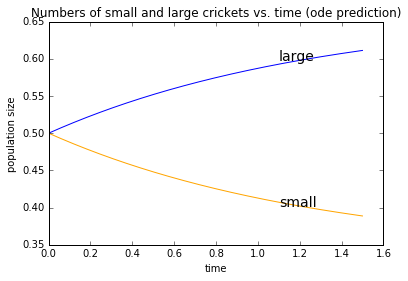

In [17]:
# Your code here
# Your code here
# Deterministic (ODE) replicator dynamics for birdie game
from scipy.integrate import odeint

F=np.array([[3,1],[5,0]])  # fitness matrix

def f(n,t):
    l = np.ones(2) #column vector of ones l
    diag = np.array([[n[0],0],[0,n[1]]])
    Ft = np.dot(F,n)
    tFt = np.dot(np.transpose(n),Ft)
    ltFt = np.dot(l,tFt)
    altFt = (Ft-ltFt)
#     return (np.dot(diag,altFt)/1.)
    return (np.dot(diag,altFt)/1.)

ninit=[1.,1.]    # initial [number of small crickets, number of large crickets]
time=np.linspace(0.0,1.5, 1000)
th0 = ninit[0]/(ninit[0]+ninit[1])
thinit = [th0, 1.-th0]
# print thinit
n=odeint(f,thinit,time)
print n

plt.plot(time,n[:,0],'orange')
plt.plot(time,n[:,1],'blue')
plt.xlabel('time')
plt.text(1.1,n[800,0], r'small',fontsize=14)
plt.text(1.1,n[800,1], r'large',fontsize=14)
plt.ylabel('population size')
plt.title("Numbers of small and large crickets vs. time (ode prediction)")

Zeros at:
0
33
100


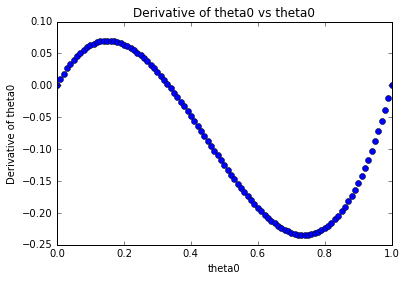

In [31]:
# Your code here
# Deterministic (ODE) replicator dynamics for birdie game
from scipy.integrate import odeint

F=np.array([[3,1],[5,0]])  # fitness matrix

def f(n):
    l = np.ones(2) #column vector of ones l
    diag = np.array([[n[0],0],[0,n[1]]])
    Ft = np.dot(F,n)
    tFt = np.dot(np.transpose(n),Ft)
    ltFt = np.dot(l,tFt)
    altFt = (Ft-ltFt)
    return (np.dot(diag,altFt)/1.)

def der(th0):
    thin = [th0, 1.-th0]
    return f(thin)

theta0 = np.linspace(0.,1.,101)
y = map(der,theta0)
theta0_p = [i[0] for i in y]
print "Zeros at:"
for i in range(np.size(theta0_p)):
    if abs(theta0_p[i]) < 4*10**-3:
        print i
plt.plot(theta0,theta0_p,'o')
# plt.plot(time,n[:,1],'blue')
plt.xlabel('theta0')
plt.ylabel('Derivative of theta0')
plt.title("Derivative of theta0 vs theta0")

__Answer__: (Your answer here)
2. The zeros are at 0, 0.33, and 1.  The points 0 and 1 are stable since they have positive slopes.

**<SPAN style="BACKGROUND-COLOR: #C0C0C0">End of Problem 5</SPAN>** 

**<SPAN style="BACKGROUND-COLOR: #C0C0C0">Problem 6:</SPAN>**  Find a 3x3 fitness matrix $F$ and an initial condition for an evolutionary game with three types of individuals such that the solution $\theta$ has a limit cycle, not just converging to a limit point.  Does the limit cycle depend on the intial state for your fitness matrix?  

Hint 1: Adapt the code you wrote for Problem 4.

Hint 2: Solve this problem by trial and error, i.e. trying different values of the entries in the fitness matrix. Think of the three types of individuals as three kinds of animals. What kind of relationship among these three animals would likely to cause an oscillating population for each animal?

[[ 0.05        0.9         0.05      ]
 [ 0.05262265  0.899862    0.04751535]
 [ 0.05538998  0.89944779  0.04516223]
 ..., 
 [ 0.79566401  0.18940598  0.01493001]
 [ 0.80382045  0.18068799  0.01549155]
 [ 0.81161508  0.17229473  0.01609019]]


Text(0.5,1,u'Numbers of small and large crickets vs. time (ode prediction)')

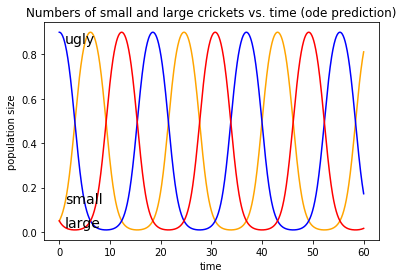

In [35]:
# Your code here
from scipy.integrate import odeint

F=np.array([[1,2,0],[0,1,2],[2,0,1]])  # fitness matrix

def f(n,t):
    l = np.ones(3) #column vector of ones l
    Ft = np.dot(F,n)
    tFt = np.dot(np.transpose(n),Ft)
    ltFt = np.dot(l,tFt)
    altFt = (Ft-ltFt)
    return (n*altFt/1.)

ninit=[.05,.9,.05]    # initial [number of small crickets, number of large crickets, number of ugly crickets]
time=np.linspace(0.0,60., 1000)

n=odeint(f,ninit,time)
print n
plt.figure(0)
plt.plot(time,n[:,0],'orange')
plt.plot(time,n[:,1],'blue')
plt.plot(time,n[:,2],'red')
plt.xlabel('time')
plt.text(1.1,n[800,0], r'small',fontsize=14)
plt.text(1.1,n[800,1], r'large',fontsize=14)
plt.text(1.1,n[800,2], r'ugly', fontsize=14)
plt.ylabel('population size')
plt.title("Numbers of small and large crickets vs. time (ode prediction)")

# def fd(n):
#     l = np.ones(3) #column vector of ones l
#     Ft = np.dot(F,n)
#     tFt = np.dot(np.transpose(n),Ft)
#     ltFt = np.dot(l,tFt)
#     altFt = (Ft-ltFt)
#     return (n*altFt/1.)

# def der(th0):
#     thin = [0.4+th0, -1/2*th0+0.3, 0.3-1/2*th0]
#     return fd(thin)


# theta0 = np.linspace(0.,30.,1000)
# y = map(der,theta0)
# theta0_p = [i[0] for i in y]
# plt.figure(1)
# plt.plot(theta0,theta0_p,'o')
# # plt.plot(time,n[:,1],'blue')
# plt.xlabel('theta0')
# plt.ylabel('Derivative of theta0')
# plt.title("Derivative of theta0 vs theta0")

__Answer__: (Your answer here)
Yes, it depends on the initial state. While one of the values in the initial state is much larger than other two, the cycle of the curve gets longer.

**<SPAN style="BACKGROUND-COLOR: #C0C0C0">End of Problem 6</SPAN>** 

For this week's lab, please answer all questions 1-6.

<div class="alert alert-block alert-warning"> 
## Academic Integrity Statement ##

By submitting the lab with this statement, you declare you have written up the lab entirely by yourself, including both code and markdown cells. You also agree that you should not share your code with anyone else. Any violation of the academic integrity requirement may cause an academic integrity report to be filed that could go into your student record. See <a href="https://provost.illinois.edu/policies/policies/academic-integrity/students-quick-reference-guide-to-academic-integrity/">Students' Quick Reference Guide to Academic Integrity</a> for more information. 